In [14]:
import csv
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

print('Done importing')

Done importing


In [23]:
# Parameters
BATCH_SIZE=24

print("===== PARAMETERS =====")
print()
print("Batch Size: ", BATCH_SIZE)

===== PARAMETERS =====

Batch Size:  24


In [24]:
samples = []
with open('./data/driving_log.csv', 'rt', encoding='utf8') as csvfile:
  reader = csv.DictReader(csvfile)
  for row in reader:
        samples.append(row)

train_samples, validation_samples = train_test_split(samples, test_size=0.2)
print('Training Set Sample Size = {}'.format(len(train_samples)))
print('Validation Set Sample Size = {}'.format(len(validation_samples)))

Training Set Sample Size = 6428
Validation Set Sample Size = 1608


In [17]:
def get_image_from_filename(filename):
    data_path = './data/' + filename
    bgr_image = cv2.imread(data_path)
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    return rgb_image

In [18]:
def flip(image, measurement):
    flipped_image = cv2.flip(image,1)
    flipped_measurement = -1.0 * measurement
    return flipped_image, flipped_measurement

In [25]:
def generator(samples, batch_size=BATCH_SIZE):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            
            images = []
            measurements = []
            for batch_sample in batch_samples:
                center_image_filename = batch_sample['center'].lstrip()
                left_image_filename = batch_sample['left'].lstrip()
                right_image_filename = batch_sample['right'].lstrip()
                
                center_image = get_image_from_filename(center_image_filename)
                left_image = get_image_from_filename(left_image_filename)
                right_image = get_image_from_filename(right_image_filename)
                
                center_steering = float(batch_sample['steering'])
                # create adjusted steering measurements for the side camera images
                correction = 0.2
                left_steering = center_steering + correction
                right_steering = center_steering - correction
                
                # Augment data by flipping the images and steering measurements
                center_image_flipped, center_steering_flipped = flip(center_image, center_steering)
                left_image_flipped, left_steering_flipped = flip(left_image, left_steering)
                right_image_flipped, right_steering_flipped = flip(right_image, right_steering)

                images.extend([center_image, left_image, right_image, center_image_flipped, left_image_flipped, right_image_flipped])
                measurements.extend([center_steering, left_steering, right_steering, center_steering_flipped, left_steering_flipped, right_steering_flipped])
                
            X_train = np.array(images)
            y_train = np.array(measurements)
            yield shuffle(X_train, y_train)
            
train_generator = generator(train_samples, batch_size=BATCH_SIZE)
validation_generator = generator(validation_samples, batch_size=BATCH_SIZE)

In [30]:
model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
# Cropping 70 pixels from the top and 25 pixels from the bottom
model.add(Cropping2D(cropping=((70,25),(0,0))))
model.add(Convolution2D(6, 5, 5, activation='relu'))
model.add(MaxPooling2D())
model.add(Convolution2D(6, 5, 5, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(120)) 
model.add(Dense(84)) 
model.add(Dense(1)) 


model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, samples_per_epoch=6*len(train_samples), 
                    validation_data=validation_generator, nb_val_samples=6*len(validation_samples), 
                    nb_epoch=3)

model.save('model.h5')

Epoch 1/3
38568/38568 [==============================] - 69s - loss: 0.0855 - val_loss: 0.0207
Epoch 2/3
38568/38568 [==============================] - 69s - loss: 0.0178 - val_loss: 0.0186
Epoch 3/3
38568/38568 [==============================] - 69s - loss: 0.0164 - val_loss: 0.0182


dict_keys(['loss', 'val_loss'])


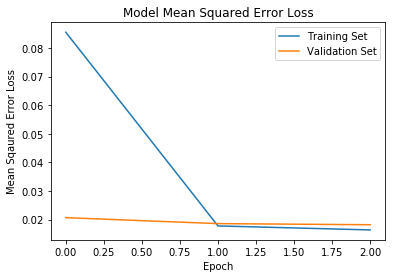

In [31]:
print(history_object.history.keys())

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('Model Mean Squared Error Loss')
plt.ylabel('Mean Sqaured Error Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set'], loc='upper right')
plt.show()